In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_csv('dataset.csv')
df.head()

,month,tourists
0,2016-01,4510
1,2016-02,5030
2,2016-03,40
3,2016-04,318
4,2016-05,6102


In [2]:
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)
df.head()

,tourists
month,
2016-01-01,4510
2016-02-01,5030
2016-03-01,40
2016-04-01,318
2016-05-01,6102


<Axes: xlabel='month'>

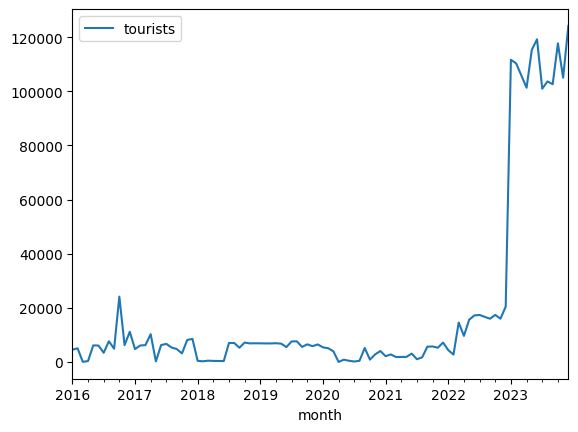

In [3]:
df.plot()

In [4]:
# Menghitung rata-rata musiman
def compute_seasonal_averages(data, period):
    seasonal_averages = {}
    for i in range(len(data) - period):
        month = data[i].month
        tourists = data[i].tourists
        if month.month not in seasonal_averages:
            seasonal_averages[month.month] = [tourists]
        else:
            seasonal_averages[month.month].append(tourists)

    seasonal_averages = {month: sum(values) / len(values) for month, values in seasonal_averages.items()}
    return seasonal_averages

In [5]:
# Membuat prediksi dengan metode Holt-Winters
def holt_winters(data, alpha, beta, gamma, period, predictions):
    level = sum(data[:period]) / period
    trend = sum([data[i + period] - data[i] for i in range(period)]) / period**2
    seasonal = {i+1: data[i] - level for i in range(period)}

    predictions.extend([level + trend + seasonal[period % 12 + 1]])
    for i in range(len(data)):
        value = data[i]
        level, trend, seasonal[period % 12 + 1] = update_values(level, trend, seasonal, alpha, beta, gamma, period % 12 + 1, value)
        predictions.append(level + trend + seasonal[period % 12 + 1])


In [6]:
# Memperbarui level, trend, dan musiman
def update_values(level, trend, seasonal, alpha, beta, gamma, period, value):
    new_level = alpha * (value - seasonal[period]) + (1 - alpha) * (level + trend)
    new_trend = beta * (new_level - level) + (1 - beta) * trend
    new_seasonal = gamma * (value - new_level) + (1 - gamma) * seasonal[period]
    return new_level, new_trend, new_seasonal

In [7]:
# Parameter Holt-Winters
alpha = 0.5
beta = 0.5
gamma = 0.5
period = 12  # Periode musiman

In [8]:
# Melakukan prediksi
predictions = []
holt_winters(df['tourists'].tolist(), alpha, beta, gamma, period, predictions)

In [9]:
predictions = [max(0, prediction) for prediction in predictions]
predictions_df = pd.DataFrame({'Prediction': predictions}).astype(int)

In [10]:
print(predictions_df.tail())

    Prediction
92      104254
93      102066
94      116756
95      107987
96      124174


In [11]:
predictions_df.to_csv('predictions_holt_wint.csv', index=False)

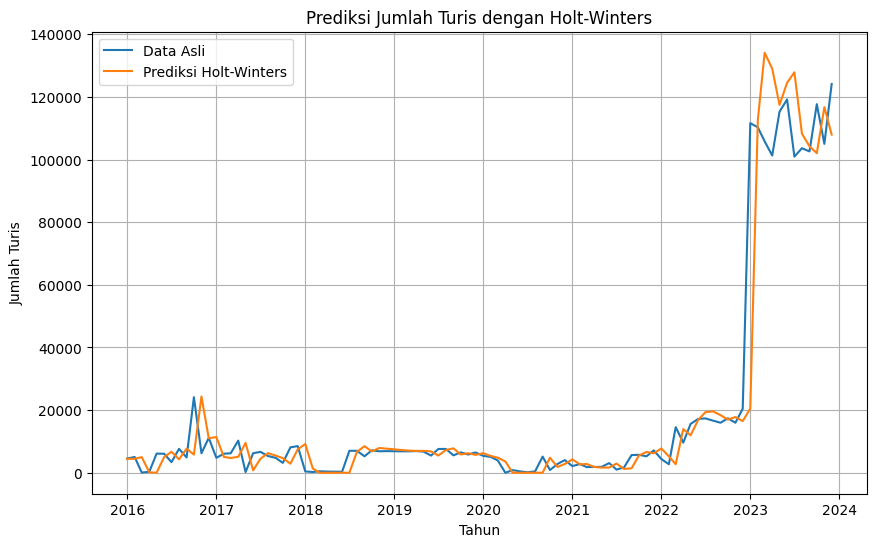

In [12]:
# Menampilkan data asli dan hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['tourists'], label='Data Asli')
plt.plot(df.index, predictions[:len(df)], label='Prediksi Holt-Winters')
plt.title('Prediksi Jumlah Turis dengan Holt-Winters')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Turis')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
total_actual = {}
total_predicted = {}

# Menghitung total jumlah wisatawan sebenarnya dan prediksi untuk setiap tahun
for i in range(8):
    year = 2016 + i
    total_actual[year] = df['tourists'][str(year)].sum()
    total_predicted[year] = sum(prediction for prediction, month in zip(predictions, df.index) if month.year == year)

# Menghitung absolute error untuk setiap tahun dan MAPE
mape_per_year = {}
for year in total_actual:
    mape_per_year[year] = abs((total_actual[year] - total_predicted[year])/total_actual[year])

mape = (sum(mape_per_year.values())/len(mape_per_year))*100

print("Mean Absolute Percentage Error (MAPE) dari 2016 sampai 2023:", mape, "%")

Mean Absolute Percentage Error (MAPE) dari 2016 sampai 2023: 3.2485571859957587 %


In [14]:
import statsmodels.api as sm

In [15]:
# Fit the SARIMAX model
model = sm.tsa.statespace.SARIMAX(df['tourists'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [16]:
# Generate predictions for the same period (2016-01 to 2023-12)
predictions = results.predict(start='2016-01-01', end='2023-12-01')

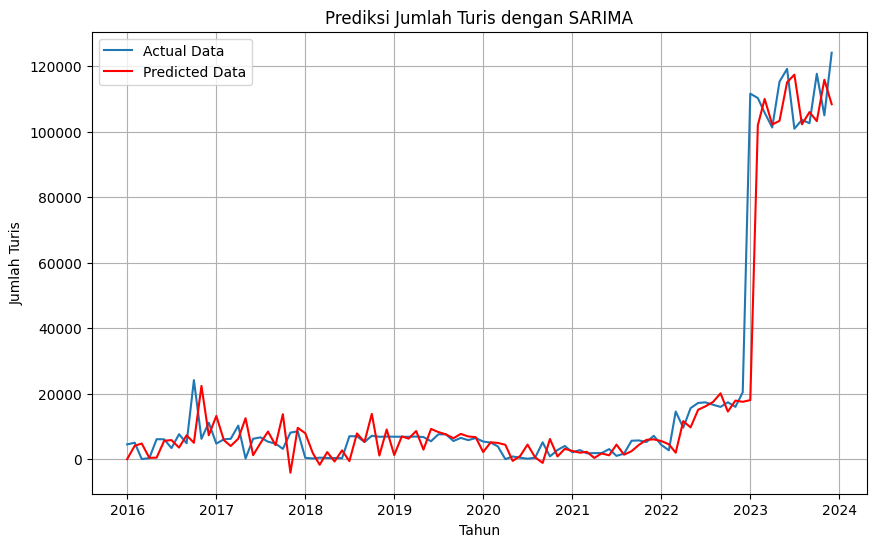

In [17]:
# Menampilkan data asli dan hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(df['tourists'], label='Actual Data')
plt.plot(predictions, label='Predicted Data', color='red')
plt.title('Prediksi Jumlah Turis dengan SARIMA')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Turis')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
predictions = [max(0, prediction) for prediction in predictions]
predictions_df = pd.DataFrame({'Prediction': predictions}).astype(int)

In [19]:
predictions_df.to_csv('predictions_Sarima.csv', index=False)

In [20]:
total_actual = {}
total_predicted = {}

# Menghitung total jumlah wisatawan sebenarnya dan prediksi untuk setiap tahun
for i in range(8):
    year = 2016 + i
    total_actual[year] = df['tourists'][str(year)].sum()
    total_predicted[year] = sum(prediction for prediction, month in zip(predictions, df.index) if month.year == year)

# Menghitung absolute error untuk setiap tahun dan MAPE
mape_per_year = {}
for year in total_actual:
    mape_per_year[year] = abs((total_actual[year] - total_predicted[year])/total_actual[year])

mape = (sum(mape_per_year.values())/len(mape_per_year))*100

print("Mean Absolute Percentage Error (MAPE) dari 2016 sampai 2023:", mape, "%")

Mean Absolute Percentage Error (MAPE) dari 2016 sampai 2023: 12.845069432494563 %
